In [41]:
# Import libraries
import requests
import pandas as pd
from io import StringIO

# Define the URL of the CSV file
url = "https://statso.io/wp-content/uploads/2023/08/Netflix-Subscriptions.csv"

# Send a GET request to download the CSV content
try:
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for non-2xx status codes

    # Check if the content type is CSV
    if 'text/csv' in response.headers.get('Content-Type', ''):
        # Convert the downloaded content to a pandas DataFrame directly
        netflix_data = pd.read_csv(StringIO(response.text))
        print(netflix_data.head())  # Display the first few rows of the DataFrame
    else:
        print("The downloaded content is not a CSV file.")
except requests.exceptions.RequestException as e:
    print(f"Error downloading file: {e}")


  Time Period  Subscribers
0  01/04/2013     34240000
1  01/07/2013     35640000
2  01/10/2013     38010000
3  01/01/2014     41430000
4  01/04/2014     46130000


In [42]:
# convert 'Time Period' to datetime
netflix_data['Time Period'] = pd.to_datetime(netflix_data['Time Period'])

# set 'Time Period' as the index
netflix_data.set_index('Time Period', inplace=True)

# display the first few rows to confirm changes
print(netflix_data.head())

             Subscribers
Time Period             
2013-01-04      34240000
2013-01-07      35640000
2013-01-10      38010000
2014-01-01      41430000
2014-01-04      46130000


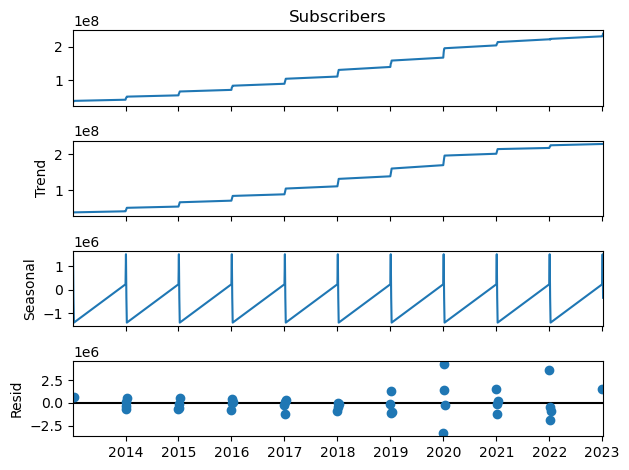

In [43]:
# Time series decomposition
import statsmodels.api as sm
import matplotlib.pyplot as plt

# decomposing the time series
decomposition = sm.tsa.seasonal_decompose(netflix_data['Subscribers'], model='additive', period=4)
decomposition.plot()
plt.show()

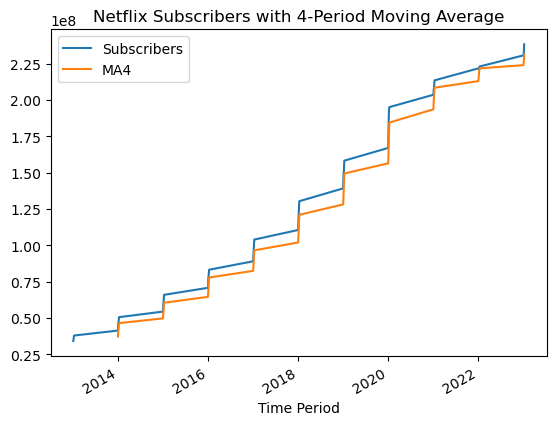

In [44]:
# calculating moving averages
netflix_data['MA4'] = netflix_data['Subscribers'].rolling(window=4).mean()

# plotting original data and moving average
netflix_data[['Subscribers', 'MA4']].plot()
plt.title('Netflix Subscribers with 4-Period Moving Average')
plt.show()

In [45]:
# Stationarity and Differencing
from statsmodels.tsa.stattools import adfuller

# perform augmented dickey-fuller test
result = adfuller(netflix_data['Subscribers'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# differencing to achieve stationarity
netflix_data['Subscribers_diff'] = netflix_data['Subscribers'].diff().dropna()

# re-perform ADF test on differenced data
result_diff = adfuller(netflix_data['Subscribers_diff'].dropna())
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])

ADF Statistic: 0.20591078338329308
p-value: 0.9725911700133492
ADF Statistic (Differenced): -4.523088428253381
p-value (Differenced): 0.00017858926729786263


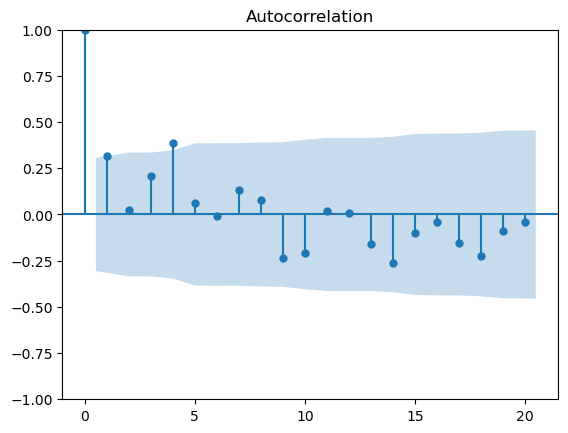

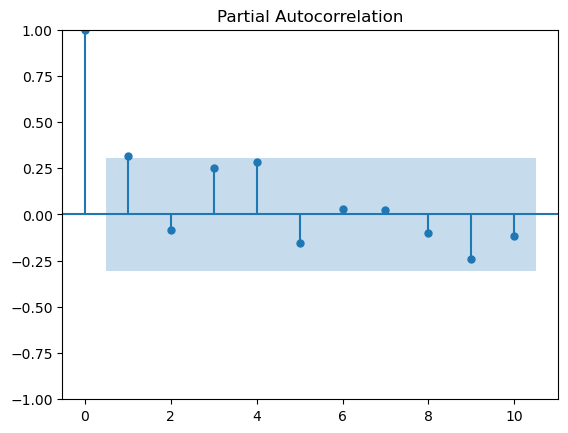

In [46]:
# Autocorrelation and Partial Autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plotting ACF and PACF
plot_acf(netflix_data['Subscribers_diff'].dropna(), lags=20)
plt.show()

plot_pacf(netflix_data['Subscribers_diff'].dropna(), lags=10)
plt.show()

In [47]:
# extract day of the month
netflix_data['DayOfMonth'] = netflix_data.index.day

# extract day of the week (Monday=0, Sunday=6)
netflix_data['DayOfWeek'] = netflix_data.index.dayofweek

# extract day name (e.g., Monday, Tuesday)
netflix_data['DayName'] = netflix_data.index.day_name()

# display the dataset with extracted day information
print(netflix_data.head())

             Subscribers         MA4  Subscribers_diff  DayOfMonth  DayOfWeek  \
Time Period                                                                     
2013-01-04      34240000         NaN               NaN           4          4   
2013-01-07      35640000         NaN         1400000.0           7          0   
2013-01-10      38010000         NaN         2370000.0          10          3   
2014-01-01      41430000  37330000.0         3420000.0           1          2   
2014-01-04      46130000  40302500.0         4700000.0           4          5   

               DayName  
Time Period             
2013-01-04      Friday  
2013-01-07      Monday  
2013-01-10    Thursday  
2014-01-01   Wednesday  
2014-01-04    Saturday  


In [51]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

netflix_data.head()

,Subscribers,MA4,Subscribers_diff,DayOfMonth,DayOfWeek,DayName
Time Period,,,,,,
2013-01-04,34240000,NaN,NaN,4,4,Friday
2013-01-07,35640000,NaN,1400000.0,7,0,Monday
2013-01-10,38010000,NaN,2370000.0,10,3,Thursday
2014-01-01,41430000,37330000.0,3420000.0,1,2,Wednesday
2014-01-04,46130000,40302500.0,4700000.0,4,5,Saturday


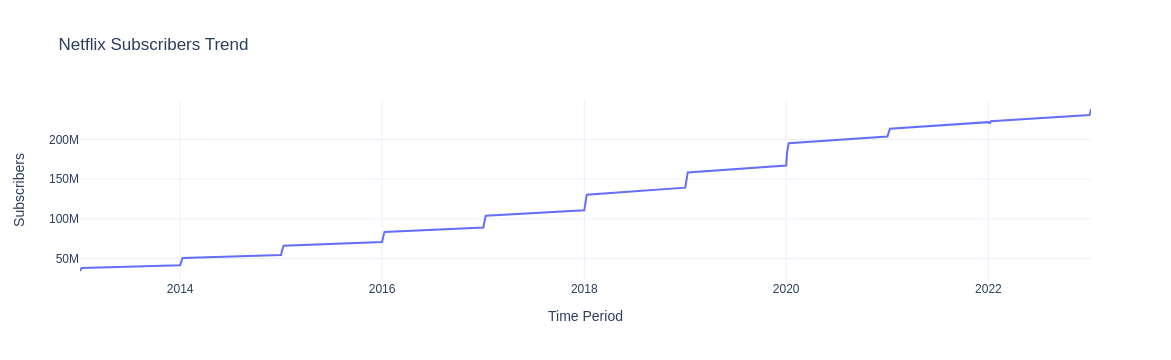

In [49]:
# Visualizing the trend of the data
import plotly.graph_objs as go
import plotly.io as pio
pio.templates.default = "plotly_white"

fig = go.Figure()
fig.add_trace(go.Scatter(x=netflix_data.index,
                         y=netflix_data['Subscribers'],
                         mode='lines', name='Subscribers'))

fig.update_layout(title='Netflix Subscribers Trend', xaxis_title='Time Period', yaxis_title='Subscribers')

fig.show()


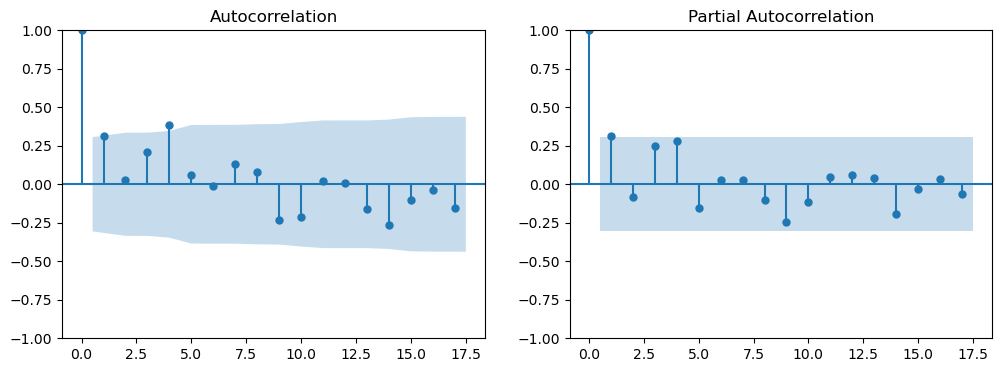

In [52]:
# Import necessary libraries for time series analysis and visualization
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Creating a time series from the 'Subscribers' column
time_series = netflix_data['Subscribers']

# Differencing
differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()


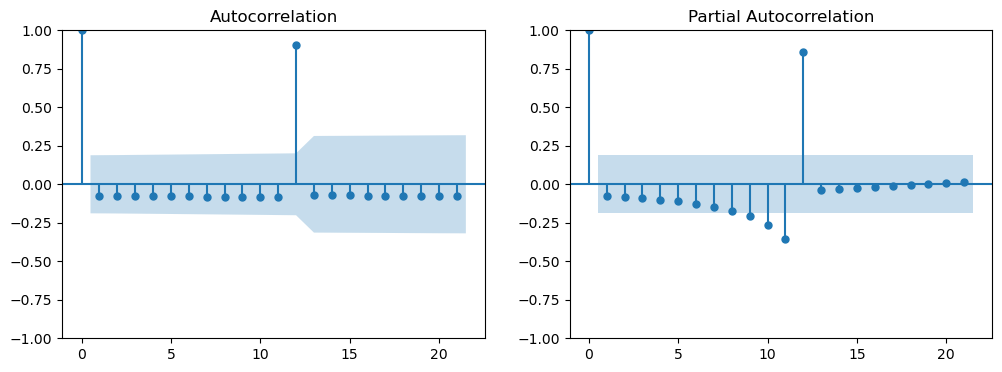

                               SARIMAX Results                                
Dep. Variable:            Subscribers   No. Observations:                  120
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1863.772
Date:                Fri, 31 May 2024   AIC                           3733.543
Time:                        20:48:57   BIC                           3741.881
Sample:                    02-01-2013   HQIC                          3736.929
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.003    291.180      0.000       0.993       1.007
ma.L1         -0.9972      0.098    -10.145      0.000      -1.190      -0.805
sigma2        4.4e+13   2.43e-15   1.81e+28      0.0

In [55]:
# Import necessary libraries for time series analysis and visualization
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Ensure the index has a frequency (monthly frequency assumed)
netflix_data = netflix_data.asfreq('MS')

# Fill any missing values (if necessary)
netflix_data['Subscribers'] = netflix_data['Subscribers'].fillna(method='ffill')

# Creating a time series from the 'Subscribers' column
time_series = netflix_data['Subscribers']

# Differencing
differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

# Fit ARIMA model
p, d, q = 1, 1, 1  # d = 1 because the data is non-stationary
model = ARIMA(time_series, order=(p, d, q))
results = model.fit()

print(results.summary())

In [56]:
# Fit ARIMA model
p, d, q = 1, 1, 1  # d = 1 because the data is non-stationary
model = ARIMA(time_series, order=(p, d, q))
results = model.fit()

print(results.summary())


                               SARIMAX Results                                
Dep. Variable:            Subscribers   No. Observations:                  120
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1863.772
Date:                Fri, 31 May 2024   AIC                           3733.543
Time:                        20:49:04   BIC                           3741.881
Sample:                    02-01-2013   HQIC                          3736.929
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.003    291.180      0.000       0.993       1.007
ma.L1         -0.9972      0.098    -10.145      0.000      -1.190      -0.805
sigma2        4.4e+13   2.43e-15   1.81e+28      0.0

In [57]:
# Predict future values
future_steps = 100
predictions = results.predict(len(time_series), len(time_series) + future_steps - 1)
print(predictions)

2023-02-01    2.324809e+08
2023-03-01    2.342116e+08
2023-04-01    2.359423e+08
2023-05-01    2.376729e+08
2023-06-01    2.394034e+08
                  ...     
2031-01-01    3.965129e+08
2031-02-01    3.982354e+08
2031-03-01    3.999578e+08
2031-04-01    4.016801e+08
2031-05-01    4.034023e+08
Freq: MS, Name: predicted_mean, Length: 100, dtype: float64


In [60]:
# Set initial parameter values and seasonal parameter values
p, d, q, s = 1, 1, 1, 12

# Fit SARIMAX model with initial parameters and constraints
model = SARIMAX(time_series, order=(p, d, q), seasonal_order=(p, d, q, s), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(maxiter=200)

# Display summary of the model fit
print(results.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74648D+02    |proj g|=  9.36966D+03


 This problem is unconstrained.



At iterate    5    f=  1.25273D+01    |proj g|=  1.81894D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6     20      1     0     0   1.819D-01   1.253D+01
  F =   12.527255645341524     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                        Subscribers   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1503.271
Date:                            Fri, 31 May 2024   AIC                           3016.5


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
